In [12]:
#Coined Simulation Functions
%matplotlib inline
from numpy import *
from matplotlib.pyplot import *
from IPython.display import HTML, display, Image

def coins(Matrix):
    if Matrix == "H":
        coin = array([[1/sqrt(2) , 1/sqrt(2)],[1/sqrt(2) , -1/sqrt(2)]])
    elif Matrix == "X":
        coin = array([0,1],[1,0])
    return coin

def init_state(N,P,CoinState):
    initstate = zeros((N,1))
    initstate[P][0] = 1
    g = kron(CoinState,initstate)
    return g

def init_coin(init):
    if init == "0":
        psi0 = array([[1],[0]])
    if init == "1":
        psi0 = array([[0],[1]])
    if init == "01":
        psi0 = array([[1/sqrt(2)],[(-1*1j)/sqrt(2)]])
    return psi0

def walk_op(N,state0,state1):
    c00= outer(state0,state0)
    c01= outer(state0,state1)
    c10= outer(state1,state0)
    c11= outer(state1,state1)
    ShiftPlus = roll(eye(N),1,axis=0)
    ShiftMinus = roll(eye(N),-1,axis=0)
    Shift = kron(c00,ShiftPlus) + kron(c11,ShiftMinus) 
    return Shift

def CU_op(coin, shift,N):
    U = shift.dot(kron(coin,eye(N)))
    return U

def final_state(U,psi0,steps):
    for t in range(0,steps):
        psi0=U.dot(psi0)
    return psi0

def prob_vec(psiN,N):
    probs = zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*conjugate(psiN[x]) + psiN[N+x]*conjugate(psiN[N+x]) #duvida aqui
    return probs

def cqwalk(N,steps,coinstate):
    P = int((N+1)/2)
    state0 = array([1,0])
    state1 = array([0,1])
    Coin = coins("H")
    shift= walk_op(N,state0,state1)
    U = CU_op(Coin,shift,N)
    amp = array([1])
    psi0 = init_state(N,P,coinstate)
    psiN = final_state(U,psi0,steps)
    probvec = prob_vec(psiN,N)
    return probvec

In [13]:
#Qiskit Functions
import sys
sys.path.append('../Tools')
from IBMTools import( 
        simul,
        savefig,
        saveMultipleHist,
        printDict,
#        plotMultipleQiskit,
        plotMultipleQiskitIbm,
        plotMultipleQiskitIbmSim,
        multResultsSim,
        setProvider,
        leastBusy,
        listBackends,
        getJob)
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from qiskit import( ClassicalRegister,
        QuantumRegister,
        QuantumCircuit,
        execute,
        Aer,
        IBMQ,
        transpile)
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy
from qiskit.providers.aer.noise import NoiseModel
from qiskit.visualization import( plot_histogram,
                        plot_state_city,
                        plot_gate_map, 
                        plot_circuit_layout)
from math import (log,ceil)
plt.rcParams['figure.figsize'] = 11,8
matplotlib.rcParams.update({'font.size' : 15})


#CNot decomposition
def cnx(qc,*qubits):
    if len(qubits) >= 3:
        last = qubits[-1]
        #A matrix: (made up of a  and Y rotation, lemma4.3)
        qc.crz(np.pi/2, qubits[-2], qubits[-1])
        #cry
        qc.cu(np.pi/2, 0, 0,0, qubits[-2],qubits[-1])
        #Control not gate
        cnx(qc,*qubits[:-2],qubits[-1])
        #B matrix (cry again, but opposite angle)
        qc.cu(-np.pi/2, 0, 0,0, qubits[-2], qubits[-1])
        #Control
        cnx(qc,*qubits[:-2],qubits[-1])
        #C matrix (final rotation)
        qc.crz(-np.pi/2,qubits[-2],qubits[-1])
   # elif len(qubits)==3:
   #     qc.ccx(*qubits)
    elif len(qubits)==2:
        qc.cx(*qubits)
    return qc

def incr(qwc,q,subnode,n):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.barrier()
        else:
            cnx(qwc,subnode[0],*q[-1:j:-1])
           # qwc.barrier()
    return qwc

def decr(qwc,q,subnode,n):
    qwc.x(subnode[0])
    c=0
    qwc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            #c+=1
            cnx(qwc,subnode[0],*q[-1::-1])
            #qwc.x(q[c])
            #qwc.barrier()
        else:
            #c+=1
            cnx(qwc,subnode[0],*q[-1:j:-1])
            #if(c==n):
                #break
            #qwc.x(q[c])
            #qwc.barrier()
    qwc.x(q[-1:0:-1])
    qwc.x(subnode[0])
    return qwc

def incrCirc(qc,q,subnode,n,toGate):
    for j in range(-1,n-1):
        if(j==-1):
            cnx(qc,subnode[0],*q[-1::-1])
        else:
            cnx(qc,subnode[0],*q[-1:j:-1])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INC      '
    return qc

def decrCirc(qc,q,subnode,n,toGate):
    qc.x(subnode[0])
    c=0
    qc.x(q[-1:0:-1])
    for j in range(-1,n-1):
        if(j==-1):
            c+=1
            cnx(qc,subnode[0],*q[-1::-1])
            qc.x(q[c])
        else:
            c+=1
            cnx(qc,subnode[0],*q[-1:j:-1])
            if(c==n):
                break
            qc.x(q[c])
    qc.x(subnode[0])
    if toGate:
        qc = qc.to_gate()
        qc.name = '      DEC      '
    return qc

def runWalk(N,steps,stateVec):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N)
    qsub = QuantumRegister(1)
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    qwc.x(qreg[0])
    for i in range(0,steps):
        qwc.h(qsub[0])
        qwc.barrier()
        incr(qwc,qreg,qsub,N)
        qwc.barrier()
        decr(qwc,qreg,qsub,N)
        qwc.barrier()
    if not stateVec:
        qwc.measure(qreg,creg)
    return qwc


def circRunWalk(N,steps,toGate):
    "Creates a single instance of the coined quantum walk cicuit."
    qreg = QuantumRegister(N,name='node')
    qsub = QuantumRegister(1, name='coin')
    creg = ClassicalRegister(N)
    qwc = QuantumCircuit(qreg,qsub,creg)
    incrCirc1 = QuantumCircuit(qreg,qsub)
    decrCirc1 = QuantumCircuit(qreg,qsub)
    incrCirc1 = incrCirc(incrCirc1,qreg,qsub,N,toGate)
    decrCirc1 = decrCirc(decrCirc1,qreg,qsub,N,toGate)
    qwc.x(qreg[0])
    qwc.h(qsub[0])
    qwc.barrier()
    for i in range(0,steps):
        qwc.append(incrCirc1,[N]+list(range(0,N)))
        qwc.append(decrCirc1,[N]+list(range(0,N)))
        qwc.barrier()
        if i!=steps-1:
            qwc.h(qsub[0])
    qwc.measure(qreg,creg)
    return qwc

def initialCond(string,N,toGate):
    qc = QuantumCircuit(N+1)
    for x in range(N):
        if string[x] == '1':
            qc.x(x)
    qc.h(N)
    if toGate:
        qc = qc.to_gate()
        qc.name = '      INIT      '
    return qc

def printIncr(N,steps,style):
    "Creates a single instance of the coined quantum walk cicuit."
    for n in N:
        qreg = QuantumRegister(n,name='node')
        qsub = QuantumRegister(1, name='coin')
        incrCirc1 = QuantumCircuit(qreg,qsub)
        incrCirc1 = incrCirc(incrCirc1,qreg,qsub,n,False)
        fig = incrCirc1.draw(output='mpl',style=style) 
    return fig 

def printDecr(N,steps,style):
    "Creates a single instance of the coined quantum walk cicuit."
    for n in N:
        qreg = QuantumRegister(n,name='node')
        qsub = QuantumRegister(1, name='coin')
        decrCirc1 = QuantumCircuit(qreg,qsub)
        decrCirc1 = decrCirc(decrCirc1,qreg,qsub,n,False)
        fig = decrCirc1.draw(output='mpl',style=style) 
    return fig 

def drawCirc(circMultWalk,style):
    for circList in circMultWalk:
        for circ in circList:
            fig = circ.draw(output='mpl',style=style)
    return fig

def baseResultDict(n,decimal):
    "Retuns a dictionary composed of a range of N keys converted to binary."
    baseDict = {}
    if decimal:
        for decNumber in range(2**n):
            dec = decNumber 
            baseDict[dec] = 0
    else:
        for decNumber in range(2**n):
            decToBin = bin(decNumber)[2:].zfill(ceil(log(2**n,2)))
            baseDict[str(decToBin)] = 0  
    return baseDict

def normalizedResultDict(baseDict,qiskitDict):
    "Returns the result of merging qiskit produced dictionaries with dictionaries produced from multBinResultDict for graph formatting reasons."
    new_d1 = baseDict
    new_d2= qiskitDict
    normalizedResultDict = {**new_d1,**new_d2}
    return normalizedResultDict

def resultsSim(N,circ,shots,Decimal):
    "Returns the dictionary produced by QASM simulator with the MSB changed to convention, and values (previously frequencies) converted to probabilities."
    result = simul(circ,False,shots)
    baseDict = baseResultDict(N,Decimal)
    if Decimal:
        correctedResultAux = { int(k[::-1],2) : v/shots for k, v in result.items()}
    else:
        correctedResultAux = { k[::-1] : v/shots for k, v in result.items()}
    correctedResult = normalizedResultDict(baseDict,correctedResultAux)
    return correctedResult

In [ ]:
#Continous Simulation Functions


# Quantum Random Walks
## by Jaime Pereira Santos

Fazer introducao com Turing, algoritmos probabilisticos e random walk classica.

## Coined Quantum Walk

$$
\newcommand{\ket}[1]{\left|{#1}\right\rangle}
\newcommand{\bra}[1]{\left\langle{#1}\right|}
$$
The space of our coined quantum walk (CQW) is composed by the coin $\mathcal{H_C}$ and walker spaces $\mathcal{H_W}$, therefore

\begin{equation}
\mathcal{H} = \mathcal{H_C} \otimes \mathcal{H_W}
\end{equation}

The principles of the walk are the same as in the classical case; if the coin is tossed and rolls "heads", for example, the system transitions to position  $\ket{x+1}$, otherwise it advances to  $\ket{x-1}$.\par 
However, since the system is allowed to be in a superposition of states, it will interfere constructively and destructively with itself, producing a behaviour unlike anything in the classical quantum walk case.

Considering a quantum random walk on a cyclic graph, where each vertex only has 2 neighbors, the coin will be a single qubit unitary operator defined as

\begin{equation}
        \begin{cases}
                C\ket{0}\ket{x} = a\ket{0}\ket{x} + b\ket{1}\ket{x}\\
                C\ket{1}\ket{x} = c\ket{0}\ket{x} + d\ket{1}\ket{x},
        \end{cases}
\end{equation}

where  a, b, c and d are the amplitudes associated with each outcome of the coin toss. In this example, a balanced coined will be considered, therefore it will simply be the Hadamard operator

\begin{equation}
        C_H = \begin{pmatrix} 
                a & c\\
                b & d
            \end{pmatrix}
            =\frac{1}{\sqrt{2}} \begin{pmatrix}
                                        1 & 1\\
                                        1 & -1
                               \end{pmatrix},
\end{equation}


Blablabla

In [28]:
coin = array([[1/sqrt(2) , 1/sqrt(2)],
              [1/sqrt(2), -1/sqrt(2)]
             ])
print(coin)

[[ 0.70710678  0.70710678]
 [ 0.70710678 -0.70710678]]


We can describe the shift operator as

\begin{eqnarray}
    S\ket{0}\ket{x} &=& \ket{0}\ket{x+1}\\
    S\ket{1}\ket{x} &=& \ket{1}\ket{x-1} \nonumber
\end{eqnarray}
    
and S in the computational basis has the format
    \begin{eqnarray}
        S = \ket{0}\bra{0} \otimes \sum_{x} \ket{x+1}\bra{x}+ \ket{1}\bra{1} \otimes \sum_{x} \ket{x-1}\bra{x}&& 
    \end{eqnarray}

In [14]:
N = 5
c00 = outer(array([1,0]),array([1,0]))
c11 = outer(array([0,1]),array([0,1])) 

ShiftPlus = roll(eye(N),1,axis=0)
ShiftMinus = roll(eye(N),-1,axis=0)

shift=kron(c00,ShiftPlus) + kron(c11,ShiftMinus)
print(shift)

[[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


It follows that the operator that describes the dynamics of the quantum walk will be given by

\begin{equation}
       U = S(C \otimes I_N) \quad \longrightarrow \quad S(C_H\otimes I)
\end{equation}

In [108]:
U = shift.dot(kron(coin,eye(N)))
print(U.round(3))

[[ 0.     0.     0.     0.     0.707  0.     0.     0.     0.     0.707]
 [ 0.707  0.     0.     0.     0.     0.707  0.     0.     0.     0.   ]
 [ 0.     0.707  0.     0.     0.     0.     0.707  0.     0.     0.   ]
 [ 0.     0.     0.707  0.     0.     0.     0.     0.707  0.     0.   ]
 [ 0.     0.     0.     0.707  0.     0.     0.     0.     0.707  0.   ]
 [ 0.     0.707  0.     0.     0.     0.    -0.707  0.     0.     0.   ]
 [ 0.     0.     0.707  0.     0.     0.     0.    -0.707  0.     0.   ]
 [ 0.     0.     0.     0.707  0.     0.     0.     0.    -0.707  0.   ]
 [ 0.     0.     0.     0.     0.707  0.     0.     0.     0.    -0.707]
 [ 0.707  0.     0.     0.     0.    -0.707  0.     0.     0.     0.   ]]


Consider a quantum system located at  $\ket{x = 0}$  with coin state  $\ket{0}$ , for  $t=0$ . It's state will be described by

\begin{equation}
        \ket{\psi(0)} = \ket{0}\ket{x=0}.
        \label{eq:coinedQWInitCond0}
\end{equation}

Applying the unitary evolution operator $t$ times

\begin{equation}
      \ket{\Psi(0)}\xrightarrow[]{\text{$U$}}\ket{\Psi(1)}\xrightarrow[]{\text{$U$}}\ket{\Psi(2)}\xrightarrow[]{\text{$U$}} (...) \xrightarrow[]{\text{$U$}}\ket{\Psi(t)}
\end{equation}

will result in state

\begin{equation}
	\ket{\Psi(t)}=U^{t}\ket{\Psi(0)},
\end{equation}

In [126]:
steps = 0
psi0 = init_state(N,int(N/2)+1,init_coin('0'))
psiInit = psi0
psiT = psi0
for t in range(0,steps):
    psi0 = U.dot(psi0)
    psiT = psi0
    
for d, c in zip(psiInit, psiT):
    print( d, c)


[0.] [0.]
[0.] [0.]
[0.] [0.]
[1.] [1.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]
[0.] [0.]


The probability distribution is then obtained by the Born rule
 
\begin{equation}
    p(\ket{\psi(t)}) = \lvert \ket{\psi(t)}  \rvert^2
\end{equation}


In [127]:
#TODO: Arranjar boa explicaçao para tirarmos o espaço da moeda.
probs = zeros((N,1))
for x in range(N):
        probs[x]=psiT[x]*conjugate(psiT[x]) + psiT[N+x]*conjugate(psiT[N+x])
print(probs)   

[[0.]
 [0.]
 [0.]
 [1.]
 [0.]]


Putting it all together, the _cqwalk_ function (available in this notebook) returns a probability distribution ready to be plotted.\par
For this example we consider a CQW, after $100$ steps, on cyclic graph with 200 vertices.

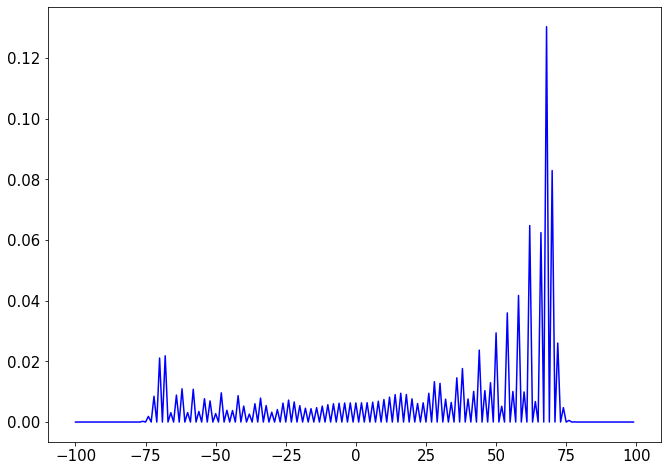

In [15]:
N = 200
steps = 100

initcondcoin0 = init_coin('0')

qw0 = cqwalk(N,steps,initcondcoin0) 

plot(arange(-N/2,N/2),qw0 ,'b')
plt.show()

The Hadamard operator flips the sign of state $\ket{1}$, hence more terms are cancelled when the coin state is $\ket{1}$. Since $\ket{0}$ was defined to _increment_ state $\ket{x}$, then it is obvious why there is a higher probability of finding the walker in the right-side of the graph.

Following this logic, it would be expected that an initial condition

\begin{equation}
        \ket{\Psi(0)} = \ket{1}\ket{x=0},
        \label{eq:coinedQWInitCond1}
\end{equation}

would result in more cancelations of terms when the coin state is $\ket{0}$, resulting in a drift towards the left-side.

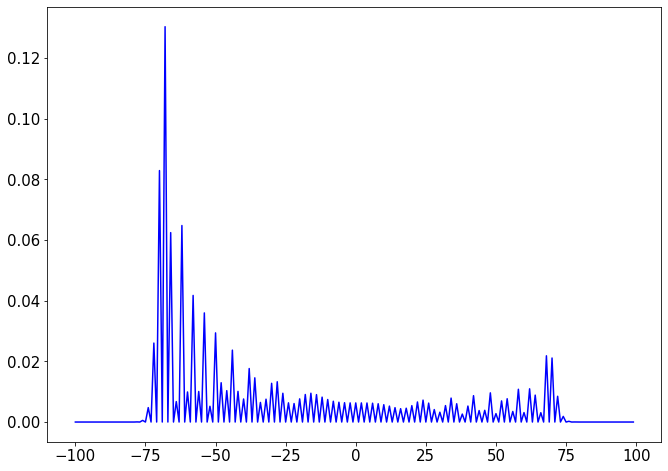

In [34]:
init1 = '1'
initcondcoin1 = init_coin(init1)
qw1 = cqwalk(N,steps,initcondcoin1)

plot(arange(-N/2,N/2),qw1 ,'b')
plt.show()

In order to obtain a symmetrical distribution, one must superpose the state in equation \ref{eq:coinedQWInitCond0} with the state in equation \ref{eq:coinedQWInitCond1}. However, in order to not cancel    terms before the calculation of the probability distribution, one must multiply state $\ket{1}$ with the imaginary unit, $i$

\begin{equation}
        \ket{\Psi(0)} = \frac{\ket{0}-i\ket{1}}{\sqrt{2}}\ket{x=0}.
        \label{eq:12}
\end{equation}


In [11]:
init01 = '01'
initcondcoin01 = init_coin(init01)
qw01 = cqwalk(N,steps,initcondcoin01)

plot(arange(-N/2,N/2),qw01 ,'b')
plt.show()

NameError: name 'steps' is not defined

In [3]:
display(HTML("""
<video width="810" height="570" controls>
  <source src="QuantumWalk500.mp4" type="video/mp4">
</video>
"""))

The probability distribution is now symmetric and it is spread over the range $[-\frac{t}{\sqrt{2}},-\frac{t}{\sqrt{2}}]$ with peaks around $x \approx \pm \frac{t}{\sqrt{2}}$. This means that if the position of the walker was measured at the end, it would be equally probable to find him either in the left side or the right side of the graph, which is not possible in a classical diffusive motion.


Escrever sobre desvio padrao e aplicacoes da quantum walk discreta.

Now, the focus is to study a quantum circuit based on the work presented by \cite{douglaswang07}. This approach relies on a set of gates that shift the state of the walker by $+1$ or $-1$, each with a probability associated with the chosen coin.

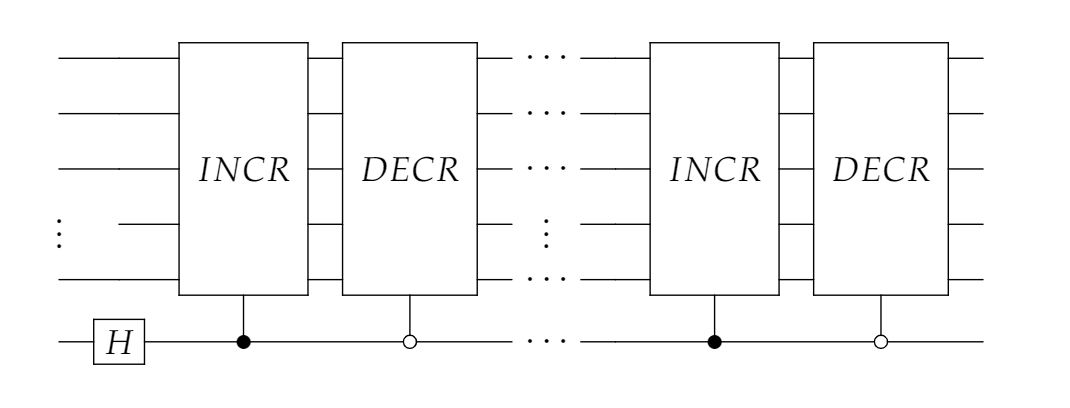

In [37]:
Image(filename = "dwcircuit.png", width=900, height=600)

The increment gate will be

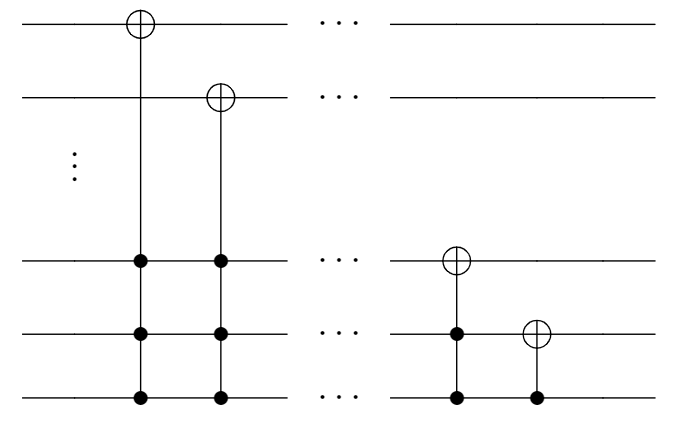

In [38]:
Image(filename = "dwincrement.png", width=700, height=600)

and the decrement gate

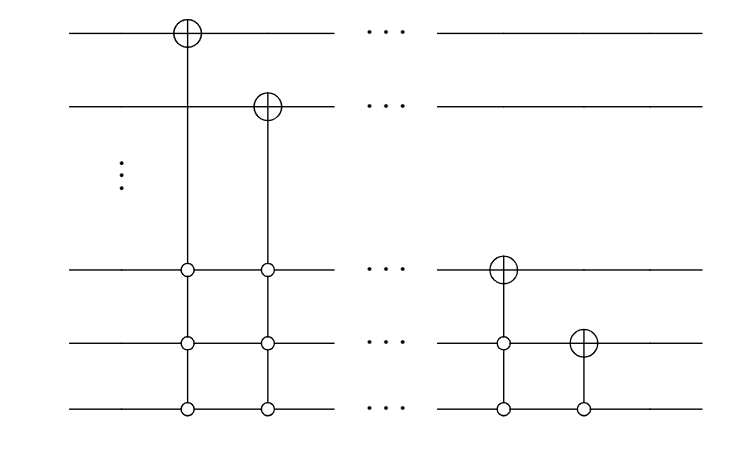

In [39]:
Image(filename = "dwdecrement.png", width=700, height=600)

The generalized CNOT gates act on the node states as a cyclic permutator, where each node is mapped to an adjacent state. This can be seen as the walker moving left or right, in the uni-dimensional graph example. \par
For a graph with $8$ nodes, for example, $3$ qubits are required to encode every vertex and an extra qubit for the coin. For a 3 step walk, we must build 3 sequences of increment and decrement gates, controlled by the coin operator.

In order to implement the Qiskit circuit, we must first find a way of creating generalized CNOT gates. One approach to this problem is to decompose an arbitrarily controlled CNOT gate into elementary gates, as was done by \cite{barenco95}. \par
In this context, the main idea is that for any unitary operator $U$, there exists operators such that

\begin{equation}
	U = \phi AXBXC,
\end{equation}

where $ABC=I$, $X$ is the Pauli-X and $\phi$ is a phase operator described by $\phi=e^{i\delta} \times I$.

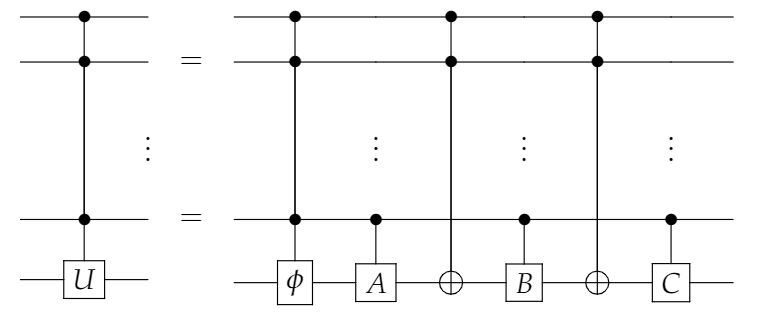

In [40]:
Image(filename = "cnotdecomp.png", width=900, height=800)

In order to understand this method, a good first example is the decomposition of the Toffoli gate.

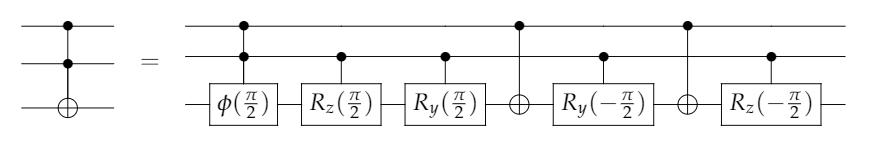

In [41]:
Image(filename = "toffolidecomp.png", width=1100, height=900)

In this case

\begin{equation}
\begin{gathered}
 A = R_z(\frac{\pi}{2}) R_y(\frac{\pi}{2}) ,
\\
 B = R_y(-\frac{\pi}{2}),
\\
 C = R_z(-\frac{\pi}{2}) .
\end{gathered}
\end{equation}

where

\begin{equation}
\begin{gathered}
R_z(\theta) = \begin{pmatrix} e^{i\frac{\phi}{2}} & 0 \\ 0 & e^{i\frac{\phi}{2}} \end{pmatrix},
\\\\
R_y(\phi) = \begin{pmatrix}cos(\frac{\theta}{2}) & -sin(\frac{\theta}{2}) \\sin(\frac{\theta}{2}) & cos(\frac{\theta}
{2})\end{pmatrix}.\\\\
\phi(\delta) = \begin{pmatrix}
		e^{i\delta} & 0 \\
		0 & e^{i\delta}
		 \end{pmatrix}
\end{gathered}
\end{equation}

Before applying gate $\phi(\frac{\pi}{2})$, the unitary operation performed on the target qubit, composed of all of the above rotations, will be 

\begin{equation}
	R_z(\frac{\pi}{2})R_y(\frac{\pi}{2})XR_y(-\frac{\pi}{2})XR_z(-\frac{\pi}{2}) = 
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} \neq X.
\end{equation}

Introducing the phase correction results in

\begin{equation}
	\phi(\frac{\pi}{2}) 
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} =  
	\begin{pmatrix}
		i & 0 \\
		0 & i
		 \end{pmatrix}   
	\begin{pmatrix}
		0 & -i \\
		-i & 0
		 \end{pmatrix} =   
	\begin{pmatrix}
		0 & 1 \\
		1 & 0
		 \end{pmatrix} = X  
\end{equation}

However, since this is a global phase, it we won't consider it in the Qiskit circuit, since it has no effect on the result of the measurement.

The increment gate in Qiskit will then be

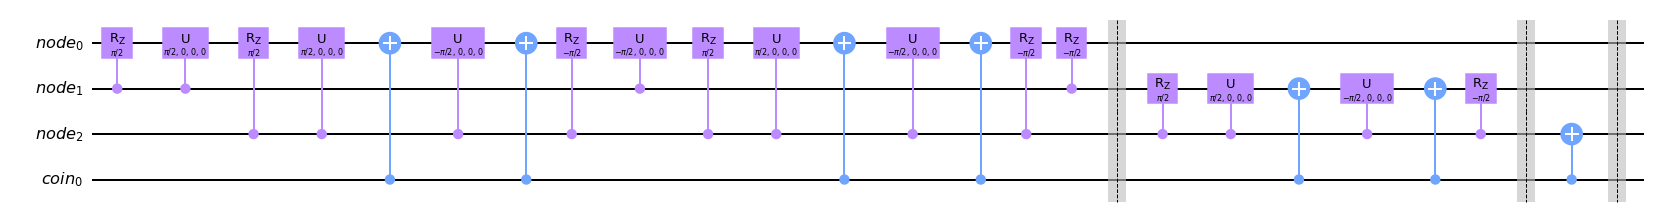

<Figure size 2172.05x264.88 with 0 Axes>

In [135]:
N = 3
qreg = QuantumRegister(N,name='node')
qcoin = QuantumRegister(1, name='coin')
qincr = QuantumCircuit(qreg,qcoin)

for j in range(-1,N-1):
    if(j==-1):
        cnx(qincr,qcoin[0],*qreg[-1::-1])
    else:
        cnx(qincr,qcoin[0],*qreg[-1:j:-1])
    qincr.barrier()
display(qincr.draw(output='mpl',fold=-1))
plt.clf()

And the decrement gate

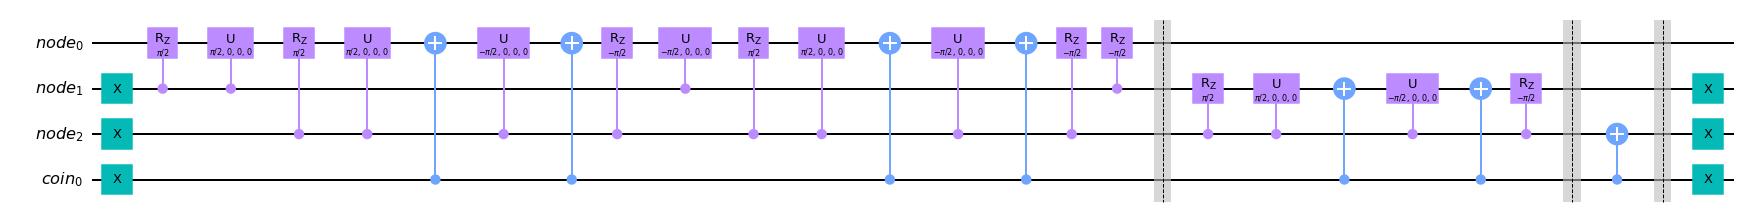

<Figure size 2292.45x264.88 with 0 Axes>

In [136]:
N = 3
qreg = QuantumRegister(N,name='node')
qcoin = QuantumRegister(1, name='coin')
qdecr = QuantumCircuit(qreg,qcoin)

qdecr.x(qcoin[0])
qdecr.x(qreg[-1:0:-1])
for j in range(-1,N-1):
    if(j==-1):
        cnx(qdecr,qcoin[0],*qreg[-1::-1])
    else:
        cnx(qdecr,qcoin[0],*qreg[-1:j:-1])
    qdecr.barrier()

qdecr.x(qreg[-1:0:-1])
qdecr.x(qcoin[0])
display(qdecr.draw(output='mpl',fold=-1))
plt.clf()

In [44]:
def increment_gate(qwc, q, subnode):
  cnx(qwc, subnode[0], q[2], q[1], q[0])
  cnx(qwc, subnode[0], q[2], q[1])
  cnx(qwc, subnode[0], q[2])
  qwc.barrier()
  return qwc

Now that we have all the operations required to perform the walk, let's see the probability distributions that result from running this circuit multiple times with initial condition $\ket{\psi(0)} = \ket{0}\ket{x=4}$ and the Hadamard coin.\par
The full circuit will be

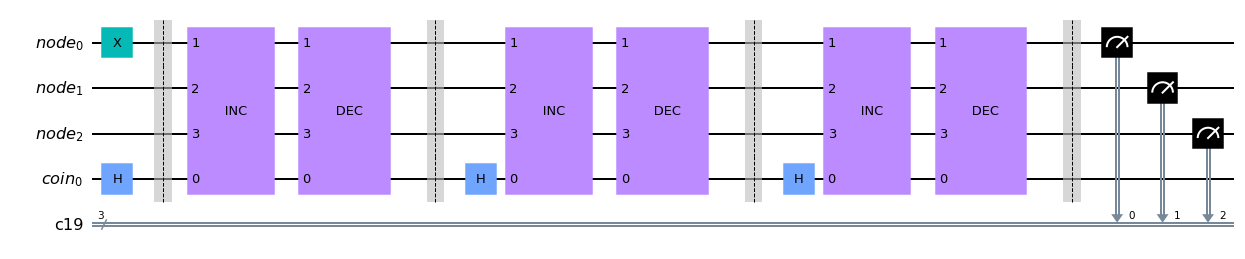

<Figure size 1630.25x325.08 with 0 Axes>

In [137]:
N = 3
steps = 3
shots = 3000
display(circRunWalk(N,steps,True).draw(output='mpl'))
plt.clf()

Let's now analyse if the probability distribution for each step makes sense.

The initial state is

\begin{equation}
	\ket{\Psi(0)} = \ket{0}\ket{4}
\end{equation}

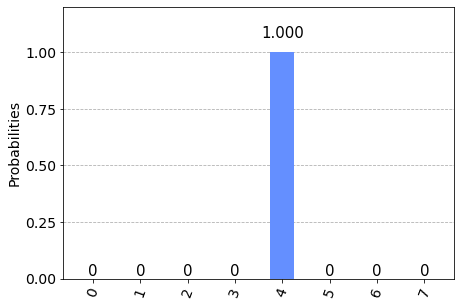

<Figure size 504x360 with 0 Axes>

In [58]:
N = 3
steps = 0
shots = 3000 
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

Since we defined the increment gate to act when coin state is $\ket{1}$, the state after the first step is

\begin{equation}
    \ket{\psi(1)} = U \ket{\psi(0)} = \frac{\ket{0}\ket{x=3}}{\sqrt{2}}+\frac{\ket{1}\ket{x=5}}{\sqrt{2}} \\\\
\end{equation}

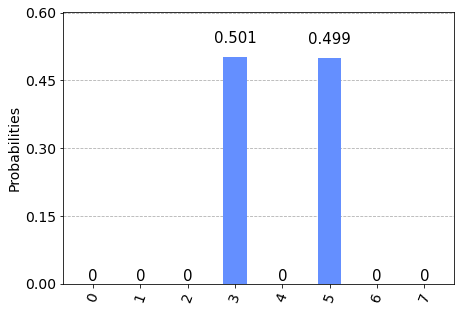

<Figure size 504x360 with 0 Axes>

In [51]:
N = 3
steps = 1
shots = 5000
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

Moving on to the second iteration

\begin{equation}
    \ket{\Psi(2)} = \frac{\ket{0}\ket{x=2}}{2}+\frac{(\ket{1}+\ket{0})\ket{x=4}}{2}-\frac{\ket{1}\ket{x=6}}{2}\\\\
\end{equation}

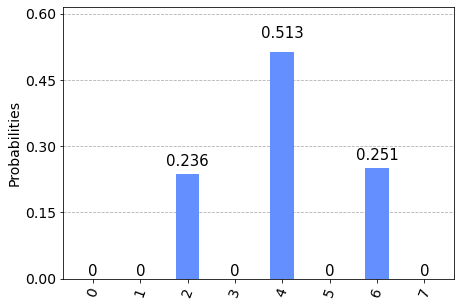

<Figure size 504x360 with 0 Axes>

In [138]:
N = 3
steps = 2
shots = 5000
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

And finally, the third step

\begin{equation}
    \ket{\Psi(3)} = \frac{\ket{0}\ket{1}}{2\sqrt{2}}+\frac{(\ket{1}+2\ket{0})\ket{3}}{2\sqrt{2}} - \frac{\ket{0}\ket{5}}{\sqrt{2}}+\frac{\ket{1}\ket{7}}{\sqrt{2}}
\end{equation}


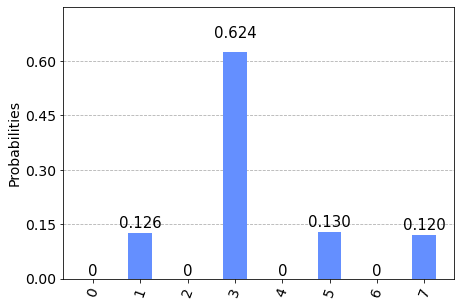

<Figure size 504x360 with 0 Axes>

In [57]:
N = 3
steps = 3
shots = 3000
qWalk = runWalk(N,steps,False)
result = resultsSim(N,qWalk,shots,True)
display(plot_histogram(result))
plt.clf()

The first few steps of the walk are not unlike the classical walk. In fact, if we were to measure the state after each application, interference between states would not happen and we would just have a regular normal distribution.\par
However, when the quantum walk is allowed to procede without intermediary measurements, the quantum effects become very apparent, as can be seen by state $\psi(3)$. Even though an unbiased coined was used, this state is not symmetric nor centered around the origin.

Decidir se ponho aqui desvio padrao + aplicaçoes

## Continuous-time Quantum Walk

In [35]:
from scipy import linalg

def circulantAdjacency(n,v):
    iv = list(range(0,n))
    av = list(range(0,n-1))
    C = np.zeros([n,n])
    for z in range(n):
        C[z,0] = v[iv[z]]    
    for x in range(1,n):
        av = iv[0:-1]
        iv[0] = iv[-1]
        iv[1::] = av
        for y in range(0,n):
            C[y,x] = v[iv[y]]
    return C

def initStateCont(N,initcond): #generalizar isto ?
    psi0 = np.zeros((N,1))
    if initcond == 'sup':
        psi0[int(N/2)-1] = 1/sqrt(2)
        psi0[int(N/2)] = 1/sqrt(2)
    if initcond== '0':
        psi0[int(N/2)] = 1
    return psi0

def final_state(Op,psi0):
    psiN = dot(Op,psi0)
    return psiN

def ct_evo(H,t,gamma):
    U = linalg.expm(-1j*gamma*H*t)
    return U

def prob_vec(psiN,N):
    probs = zeros((N,1))
    for x in range(N):
        probs[x]=psiN[x]*conjugate(psiN[x]) 
    return probs

def ctqwalk(N, A, t, gamma, initState):
    psi0 = initState
    U = ct_evo(A,t,gamma)
    psiN = final_state(U,psi0)
    probvec = prob_vec(psiN,N)
    return probvec

The Continuous-time Quantum Walk (CTQW) is an alternative model of modelling a random walk, firstly introduced by \cite{montrollweiss1965}, which does not require a coin. Because time is continuous, the walker can transition from some position $x_i$ to another $x_j$ at any time.

One way to visualize the dynamics is to imagine the probability of the walker transitioning as a fluid that is trickling from position $x_i$ to $x_j$. The probability of it being found in $x_i$ gradually shifts to $x_j$, until the walker eventually moves ahead. The increase and decrease of the probability can be described by a transition rate, $\gamma$, which is constant for all vertices and times.

In order to deal with the continuous variables, we must setup an appropriate differential equation and find it's solutions

\begin{equation}
	\frac{dp_i(t)}{dt} = \gamma \sum_j L_{ij} p_j(t), \label{contWalk}
\end{equation}
where $L$ is the Laplacian defined as $L = A - D$. $A$ is the adjacency matrix that represents each vertex connection, given by

\begin{equation}
	A_{ij} = \begin{cases} 1, & \mbox{if } (i,j)\in G \\ 0, & \mbox{otherwise,} \end{cases}
\end{equation}

and D is the diagonal matrix $D_{jj} = deg(j)$ that represents how many neighbors each vertex has.

In the quantum case, the vertices are quantum states that form the basis for the Hilbert space, which means the vector that describes the probability distribution must be converted to a state vector. The transition matrix must also be converted to an equivalemt unitary operator. What is left is the following Shrodinger equation

\begin{equation}
	i\hbar \frac{d\ket{\Psi(t)}}{dt} = H \ket{\Psi(t)}, \label{shrodinger}
\end{equation}

where $H = -\gamma L$.

Solving the equation results in the evolution operator

\begin{equation}
	U(t) = e^{-iHt} = e^{i(-\gamma L)t} = e^{-i\gamma(A+D)t}
\end{equation}

For a regular graph, $A$ and $D$ commute. This means that the evolution operator can be written in terms of the adjacency matrix, since the degree will be the identity matrix multipled by some constant making it a global phase

\begin{equation}
	U(t) = e^{-i\gamma A t + i\gamma D t} = e^{-i\gamma A t} e^{i\gamma D t} = \phi(t) e^{-i\gamma A t}.
\end{equation}

In this example we will study the CTQW on a cycle, whose adjacency matrix can be traditionally defined by

\begin{equation}
    A = \sum_{x} \ket{x+1}\bra{x} + \ket{x}\bra{x+1}
\end{equation}

However, this can be seen as an instance of a broader class of graphs, namely \textit{circulant graphs}. This kind of graph is defined by a circulant matrix

\begin{equation}\label{eq:adjc}
A = 
\begin{bmatrix}
c_0&c_{N-1}& \cdots&c_2&c_1 \\
c_1&c_0& c_{N-1}& &c_{2} \\
\vdots & c_1 & c_0 &\ddots & \vdots\\
c_{N-2}& & \ddots&\ddots &c_{N-1}\\
c_{N-1} & c_{N-2} & \cdots & c_1 & c_0\\
\end{bmatrix}.
\end{equation}


We can define the circulant matrix based on the first column vector and an operation, similar to a deque, where we move every element to the following position in a cyclic fashion. In this way, we have the first column vector as
\begin{equation}
    v_1 = [c_0,c_1,\cdots,c_{N-2}, c_{N-1}]^T
\end{equation}
and the deque operation such that
\begin{equation}
    D v_1 =[c_{N-1},c_0,\cdots,c_{N-3}, c_{N-2}]^T = v_2
\end{equation}

In [40]:
N = 5
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
A = circulantAdjacency(N,cCycle)
print(A)

[[0. 1. 0. 0. 1.]
 [1. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 1.]
 [1. 0. 0. 1. 0.]]


Now that we have the adjacency matrix, the unitary evolution operator

\begin{equation}
 U(t) = e^{-i\gamma A t}
\end{equation}

can be implemented as

In [41]:
gamma = 1/2*sqrt(2)
t = 0.2
U = linalg.expm(-1j*gamma*A*t)
print(U.round(2))

[[ 0.98-0.j    0.  -0.14j -0.01+0.j   -0.01+0.j    0.  -0.14j]
 [ 0.  -0.14j  0.98-0.j    0.  -0.14j -0.01+0.j   -0.01+0.j  ]
 [-0.01+0.j    0.  -0.14j  0.98-0.j    0.  -0.14j -0.01+0.j  ]
 [-0.01+0.j   -0.01+0.j    0.  -0.14j  0.98-0.j    0.  -0.14j]
 [ 0.  -0.14j -0.01+0.j   -0.01+0.j    0.  -0.14j  0.98-0.j  ]]


Meaning that the state of our walk after time $t$ is

\begin{equation}
	\ket{\Psi(t)} = U(t)\ket{\Psi(0)}.
\end{equation}

where 

\begin{equation}
	\ket{\Psi(0)} = \ket{0}.
\end{equation}


In [42]:
psi0 = initStateCont(N,'0')
psiN = dot(U,psi0)
print(psiN.round(2))

[[-0.01+0.j  ]
 [ 0.  -0.14j]
 [ 0.98-0.j  ]
 [ 0.  -0.14j]
 [-0.01+0.j  ]]


Transforming the amplitudes in probabilities

In [44]:
probs = zeros((N,1))
for x in range(N):
    probs[x]=psiN[x]*conjugate(psiN[x]) 
print(probs.round(2))

[[0.  ]
 [0.02]
 [0.96]
 [0.02]
 [0.  ]]


<ipython-input-44-583813e756fc>:3: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*conjugate(psiN[x])


Putting it all together in the _ctqwalk_ function (available in this notebook) allows us to plot the probability distribution. \par
For this example we consider a CQW, at $t=100$, on cyclic graph with 200 vertices, and $\gamma = \frac{1}{2\sqrt{2}}$.

<ipython-input-35-f54f1bdb7519>:37: ComplexWarning: Casting complex values to real discards the imaginary part
  probs[x]=psiN[x]*conjugate(psiN[x]) #duvida aqui


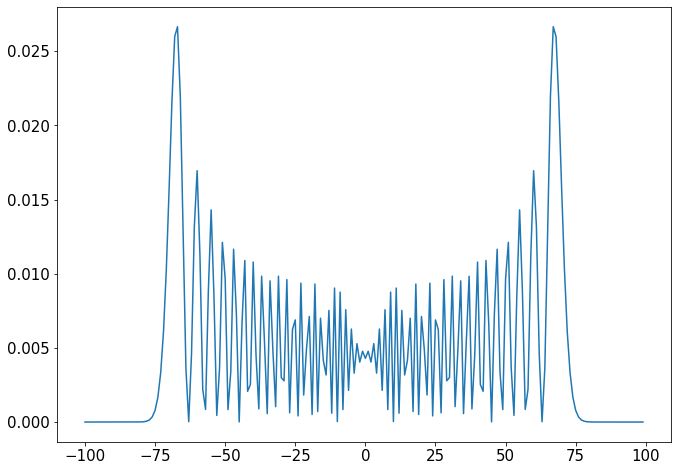

In [37]:
N = 200
t=100
cCycle = [0,1] + [0 for x in range(N-3)] + [1]
gamma = 1/(2*np.sqrt(2))
A = circulantAdjacency(N,cCycle)
initCond = '0'
initState = initStateCont(N,initCond)
qw = ctqwalk(N,A,t,gamma,initState)
plot(arange(-N/2,N/2),qw)

The choice of initial condition also has an effect in the

# References

(<a id="cit-douglaswang07" href="#call-douglaswang07">Douglas and B., 2009</a>) Douglas B.L. and B. J., ``_Efficient quantum circuit implementation of quantum walks_'', , vol. , number , pp. ,  2009.

(<a id="cit-barenco95" href="#call-barenco95">Barenco, Bennett <em>et al.</em>, 1995</a>) Barenco Adriano, Bennett Charles H., Cleve Richard <em>et al.</em>, ``_Elementary gates for quantum computation_'', Physical Review A, vol. 52, number 5, pp. 3457–3467, Nov 1995.  [online](http://dx.doi.org/10.1103/PhysRevA.52.3457)

